# 23. Convolutional AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 23.1 Preparing MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

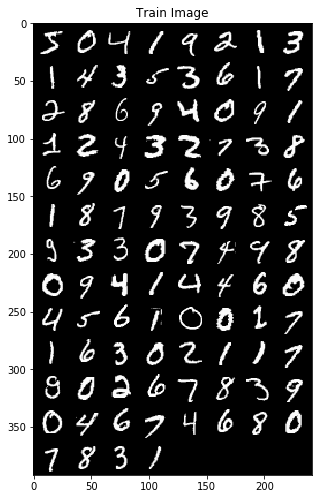

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 23.2 Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,1,28,28)
        
        return out

In [9]:
E = Encoder().cuda()
D = Decoder().cuda()

## 22.3 Model Training

In [10]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [11]:
num_epochs = 5

In [13]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = Variable(batch_images).cuda()
        
        pre = D(E(X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
    
print("Learning Finished!")

Epoch [1/5], lter [100/600] Loss: 0.0239
Epoch [1/5], lter [200/600] Loss: 0.0189
Epoch [1/5], lter [300/600] Loss: 0.0154
Epoch [1/5], lter [400/600] Loss: 0.0118
Epoch [1/5], lter [500/600] Loss: 0.0118
Epoch [1/5], lter [600/600] Loss: 0.0163
Epoch [2/5], lter [100/600] Loss: 0.0088
Epoch [2/5], lter [200/600] Loss: 0.0107
Epoch [2/5], lter [300/600] Loss: 0.0097
Epoch [2/5], lter [400/600] Loss: 0.0082
Epoch [2/5], lter [500/600] Loss: 0.0084
Epoch [2/5], lter [600/600] Loss: 0.0121
Epoch [3/5], lter [100/600] Loss: 0.0068
Epoch [3/5], lter [200/600] Loss: 0.0085
Epoch [3/5], lter [300/600] Loss: 0.0081
Epoch [3/5], lter [400/600] Loss: 0.0069
Epoch [3/5], lter [500/600] Loss: 0.0072
Epoch [3/5], lter [600/600] Loss: 0.0099
Epoch [4/5], lter [100/600] Loss: 0.0060
Epoch [4/5], lter [200/600] Loss: 0.0074
Epoch [4/5], lter [300/600] Loss: 0.0070
Epoch [4/5], lter [400/600] Loss: 0.0063
Epoch [4/5], lter [500/600] Loss: 0.0064
Epoch [4/5], lter [600/600] Loss: 0.0086
Epoch [5/5], lte

## 22.4 Test Model

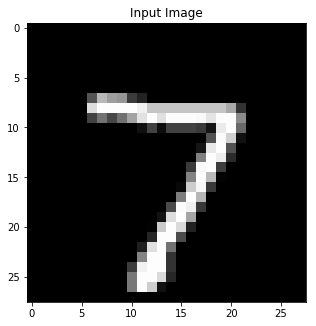

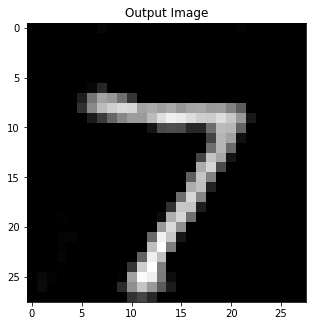

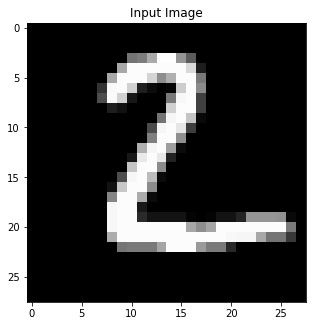

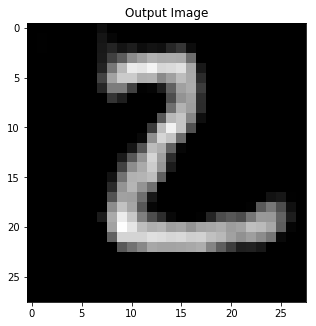

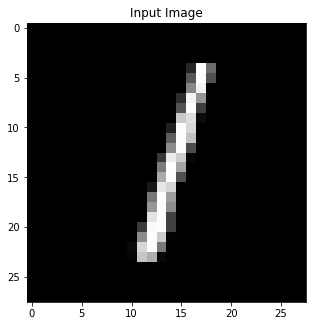

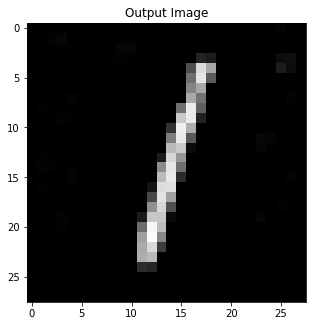

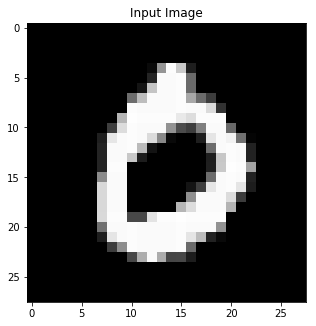

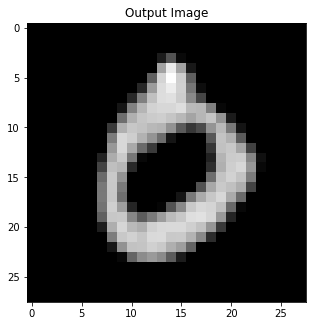

In [14]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    images = Variable(images.view(-1, 1, 28, 28)).cuda()
    
    outputs = D(E(images))
    outputs = outputs.view(-1, 1, 28, 28)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break

## 22.5 Make Random Image

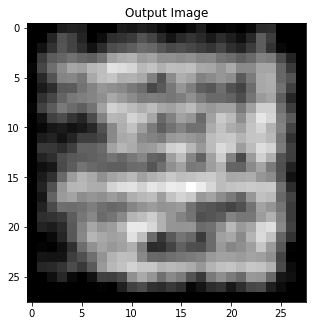

In [15]:
z = Variable(torch.rand(E(images).size())).cuda()

outputs = D(z)
outputs = outputs.view(-1, 1, 28, 28)

imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")